In [1]:
from datetime import datetime
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

pd.options.mode.chained_assignment = None

## Functions

In [2]:
def sum_dict(results:dict)->list:
    return list(map(sum, zip(*results.values())))

In [3]:
def normalize_col(column):
    return (column - column.min()) / (column.max()-column.min())

In [4]:
def df_basing(df:pd.DataFrame)->(pd.DataFrame,pd.DataFrame):
    base_df = df.iloc[:,0].fillna(method='ffill')
    diff_df = df.iloc[:,1:]
    for col in diff_df.columns:
        diff_df.loc[:,col] = diff_df.loc[:,col].div(base_df, axis=0)
    diff_df=diff_df.apply(lambda x: x-1)
    return base_df, diff_df

In [5]:
def base_plot(tickers:list, diff_df):
    fig, ax = plt.subplots(1,1,figsize = (20,10))
    ax.axhline(0 ,color="r", label = tickers[0])
    ax.plot(diff_df,label=diff_df.columns)
    ax.set_title("Difference of European Traded Stocks Versus NYSE Traded Stock")
    ax.set_xlabel("Date")
    ax.set_ylabel(f"Percentage difference to {test_tickers[0]}")
    ax.legend()

In [6]:
def extract_trading_days(df):
    filled_df = df.fillna(method='ffill')
    return [group[1].between_time("14:30","16:30") for group in filled_df.groupby(filled_df.index.day)]

In [7]:
def get_price_data(dates, tickers:list):
    dates = dates.values.flatten().tolist()
    start, end = datetime.utcfromtimestamp(dates[0]/1e9),datetime.utcfromtimestamp(dates[1]/1e9)
    
    data = [yf.Ticker(ticker).history(interval='5m', start=start, end=end)["Close"] for ticker in tickers]
    eur_usd = yf.Ticker('EUR=X').history(interval='5m', start=start, end=end)["Close"]
    
    price_df = pd.concat(data, axis=1, ignore_index=False) #price data
    price_df.columns = tickers
    eur_usd=eur_usd.reindex(price_df.index).fillna(method='ffill')
    
    dfs_to_convert = [ticker for ticker in tickers if "." in ticker]
    price_df.loc[:,dfs_to_convert] = price_df.loc[:,dfs_to_convert].multiply(eur_usd.loc[price_df.index], axis=0)
    
    return_df = pd.concat(data, axis=1, ignore_index=False) #price data
    return_df.columns = tickers
    for col in return_df.columns:
        return_df[col] = normalize_col(return_df[col])
    return price_df, return_df

In [8]:
def trade(traders:list, time_blocks, tickers:list)->list:
    total_history = []
    for i in tqdm(range(len(time_blocks))): # time block: each week
        t1,t2 = get_price_data(time_blocks.loc[i], tickers) # price df, return df
        trading_days_returns = extract_trading_days(t2)
        trading_days_price = extract_trading_days(t1)
        
        bal_history = []
        for td_return, td_price in zip(trading_days_returns,trading_days_price): # trading day: each day
            base_df, diff_df = df_basing(td_return)
            for idx in diff_df.index: # time: each timeframe (5m)
                price_data = td_price.loc[idx].values.flatten().tolist()
                return_data = diff_df.loc[idx].values.flatten().tolist()
                
                td_his = []
                for i,trader in enumerate(traders):
                    trader.data_feed(idx.time(), return_data, price_data, tickers)
                    td_his.append([idx.to_pydatetime(),trader.balance])
                bal_history.append(td_his)
        total_history.append(bal_history)
    return sum(total_history,[])

In [9]:
def download_data(time_blocks, tickers:list)
    for i in range(len(time_blocks)):

SyntaxError: expected ':' (2030268070.py, line 1)

## Get company tickers

In [9]:
companies = pd.read_excel("Stocks.xlsx")

In [10]:
company_names = companies.iloc[:,0]

In [11]:
us_tickers = companies.iloc[:,2:5]
non_us_tickers = companies.iloc[:,5:]
eu_tickers = non_us_tickers.drop(["NEO","BUE","SGO","LSE","IOB","SAO","STO","JPX","HKG","KSC","MEX"], axis = 1)

In [12]:
arb_df = us_tickers.join(eu_tickers).set_index(company_names.values).drop("Fujitsu")
display(arb_df)

,NMS,NMS2,NYQ,GER,FRA,BER,DUS,ISE,MIL,VIE,VIE2
Ryanair,RYAAY,NaN,NaN,RY4C.DE,RY4C.F,RY4D.BE,RY4D.DU,RYA.IR,NaN,NaN,NaN
Tesla,TSLA,NaN,NaN,TL0.DE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Netflix,NFLX,NaN,NaN,NFC.DE,NaN,NaN,NaN,NaN,NFLX.MI,NaN,NaN
Google,GOOG,GOOGL,NaN,ABEA.DE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Berkshire Hathaway,BRK-B,BRK-A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BRKB.VI,BRKA.VI
Amazon,AMZN,NaN,NaN,AMZ.DE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Walmart,WMT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Apple,AAPL,NaN,NaN,APC.DE,APC.F,NaN,NaN,NaN,NaN,NaN,NaN
Microsoft,MSFT,NaN,NaN,MSF.DE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
General Motors,NaN,NaN,GM,8GM.DE,8GM.F,NaN,NaN,NaN,NaN,GMOT.VI,NaN


## Get Price Data

In [13]:
starts = pd.bdate_range('2022-12-01', '2023-01-20', freq="7B").to_frame(index=False)
stops = pd.bdate_range('2022-12-08', '2023-01-27', freq="7B").to_frame(index=False)
time_blocks = pd.concat([starts,stops], axis = 1)

display(time_blocks)

,0,0
0,2022-12-01,2022-12-08
1,2022-12-12,2022-12-19
2,2022-12-21,2022-12-28
3,2022-12-30,2023-01-06
4,2023-01-10,2023-01-17
5,2023-01-19,2023-01-26


In [29]:
test_tickers = ["RYAAY","RYA.IR","RY4C.DE"]

In [30]:
t1,t2 = get_price_data(time_blocks.loc[0], test_tickers)

## Visual Analysis

<AxesSubplot:xlabel='Datetime'>

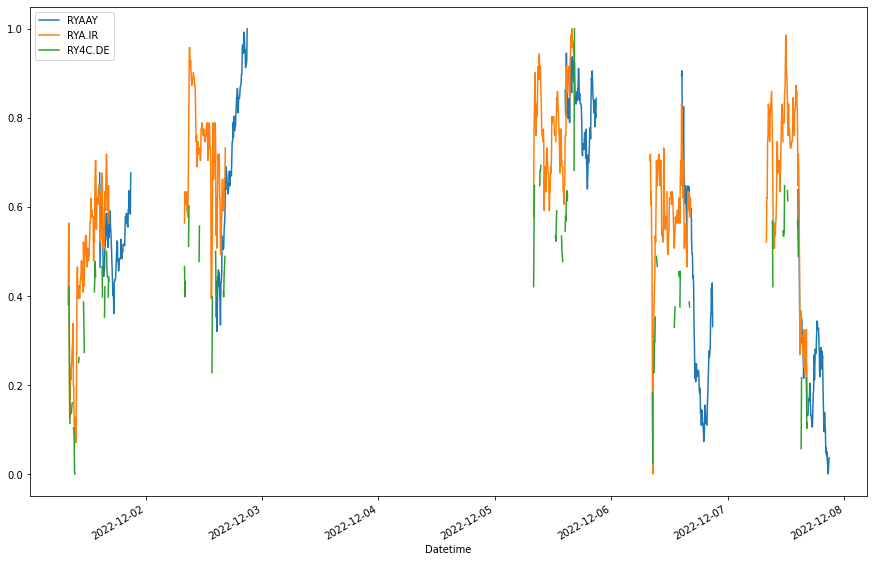

In [31]:
t2.plot(figsize=(15,10))

In [32]:
base_df, diff_df = df_basing(t2)

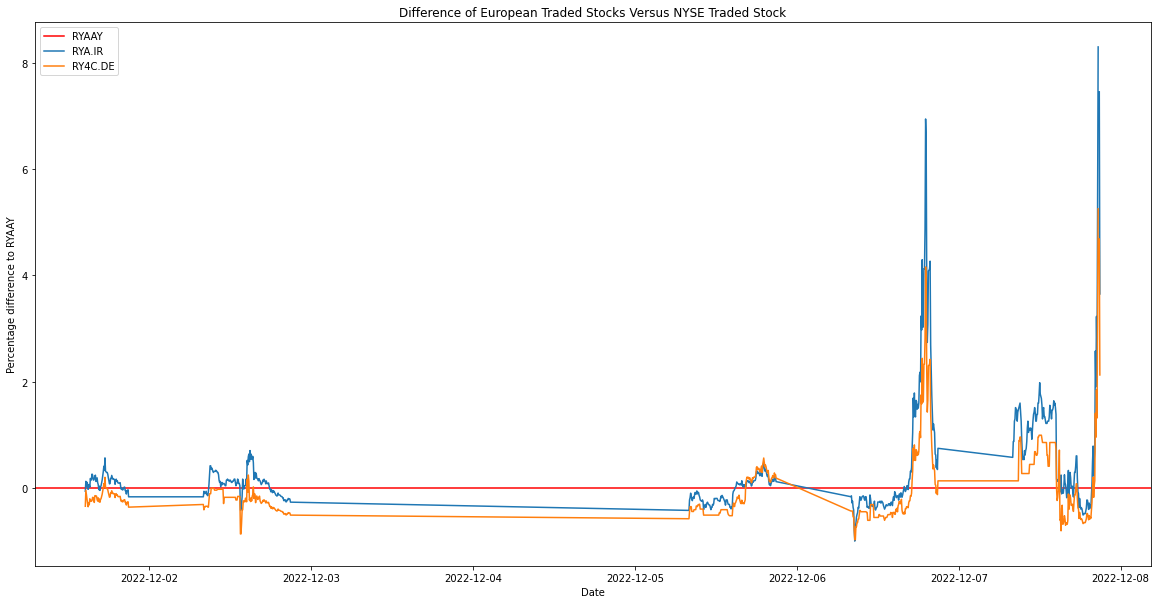

In [33]:
base_plot(test_tickers, diff_df)

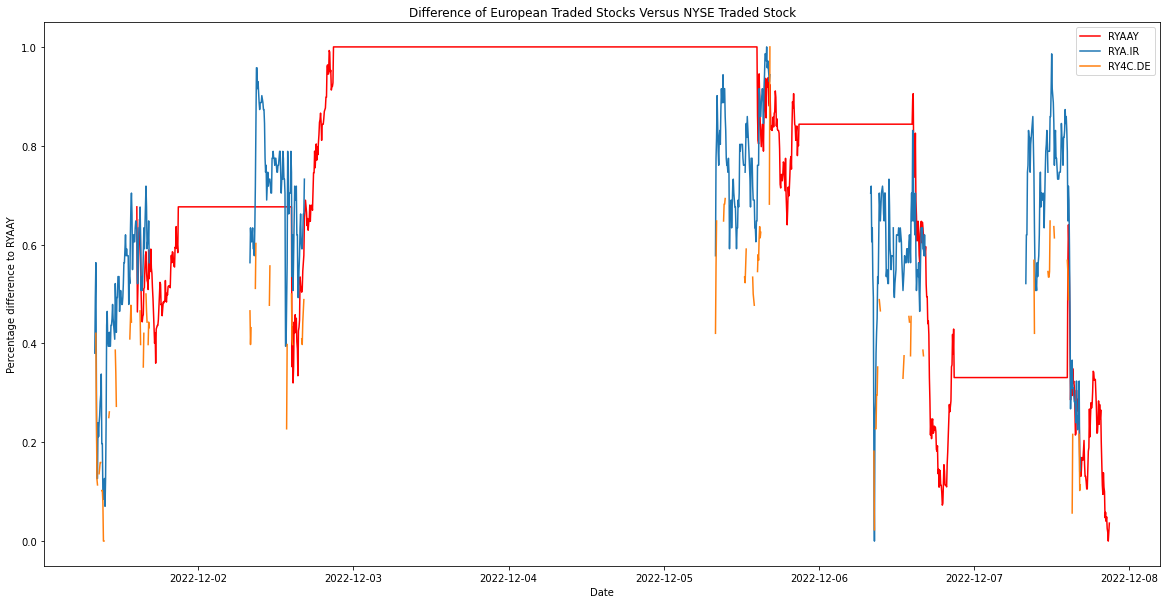

In [34]:
fig, ax = plt.subplots(1,1,figsize = (20,10))
ax.plot(base_df, label=base_df.name , color = "r")
ax.plot(t2[test_tickers[-2:]],label=t2[test_tickers[-2:]].columns)
ax.set_title("Difference of European Traded Stocks Versus NYSE Traded Stock")
ax.set_xlabel("Date")
ax.set_ylabel(f"Percentage difference to {test_tickers[0]}")
ax.legend()

## Trading Test

In [14]:
from IntradayRegionArbitrage import IntradayRegionArbitrage as IRA

In [15]:
histories = {}
trades = {}

In [16]:
for row in tqdm(arb_df.iterrows()):
    traders = [IRA(bal=1000,min_deviation=0.1,sl_percent=0.03,trigger_range=0.01,trade_size=0.1,trade_size_percent=True)]
    lst = list(row[1].dropna())
    if len(lst) > 1 and any("." in elem for elem in lst) and row[0] not in histories:
        histories[row[0]] = trade(traders, time_blocks, lst)
        trades[row[0]] = traders[0].trades

0it [00:00, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare RYAAY-> amt: -2.6190 @76.3650 --> total: -200.0000
		Ticker RYA.IR-> amt: 16.1994 @12.3461 --> total: 200.0000
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare RYAAY-> amt: 2.6190 @76.6900 --> total: 200.8512
		Ticker RYA.IR-> amt: -16.1994 @12.3708 --> total: -200.3996
	 PNL: 0.0452%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare RYAAY-> amt: -1.3153 @76.0600 --> total: -100.0452
		Ticker RY4C.DE-> amt: 8.0666 @12.4024 --> total: 100.0452
		BaseShare RYAAY-> amt: -1.3153 @76.0600 --> total: -100.0452
		Ticker RYA.IR-> amt: 8.0790 @12.3833 --> total: 100.0452
	take profit
	--Closing Trade
		BaseShare RYAAY-> amt: 1.3153 @77.5650 --> total: 102.0248
		Ticker RYA.IR-> amt: -8.0790 @12.4157 --> total: -100.3064
	 PNL: 0.1718%
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare RYAAY-> amt: 1.3153 @77.4900 --> total: 101.9261
		Ticker RY4C.DE-> amt: -8.0666

	--Opening Trade
		BaseShare RYAAY-> amt: -0.5649 @89.0350 --> total: -50.2958
		Ticker RY4C.DE-> amt: 3.6993 @13.5961 --> total: 50.2958
		BaseShare RYAAY-> amt: -0.5649 @89.0350 --> total: -50.2958
		Ticker RY4C.F-> amt: 3.7249 @13.5027 --> total: 50.2958
		BaseShare RYAAY-> amt: -0.5649 @89.0350 --> total: -50.2958
		Ticker RY4D.DU-> amt: 0.6665 @75.4677 --> total: 50.2958
		BaseShare RYAAY-> amt: -0.5649 @89.0350 --> total: -50.2958
		Ticker RYA.IR-> amt: 3.7246 @13.5036 --> total: 50.2958
	take profit
	--Closing Trade
		BaseShare RYAAY-> amt: 0.5649 @89.5900 --> total: 50.6093
		Ticker RY4C.DE-> amt: -3.6993 @13.4387 --> total: -49.7135
	 PNL: 0.0891%
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare RYAAY-> amt: 0.5649 @89.5900 --> total: 50.6093
		Ticker RY4C.F-> amt: -3.7249 @13.5303 --> total: -50.3987
	 PNL: 0.0209%
	--Closing Trade
		BaseShare RYAAY-> amt: 0.5649 @89.5900 --> total: 50.6093
		Ticker RYA.IR-> amt: -3.7246 @13.4573 --> total: -50.1233
	 PNL: 0.0483

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare TSLA-> amt: -1.1581 @172.6900 --> total: -200.0000
		Ticker TL0.DE-> amt: 1.2766 @156.6601 --> total: 200.0000
	take profit
	--Closing Trade
		BaseShare TSLA-> amt: 1.1581 @172.9800 --> total: 200.3359
		Ticker TL0.DE-> amt: -1.2766 @157.1167 --> total: -200.5830
	 PNL: -0.0247%
	Market-Closing --> close Trades
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare TSLA-> amt: -1.6896 @118.3400 --> total: -199.9506
		Ticker TL0.DE-> amt: 1.9476 @102.6638 --> total: 199.9506
	take profit
	--Closing Trade
		BaseShare TSLA-> amt: 1.6896 @118.2397 --> total: 199.7811
		Ticker TL0.DE-> amt: -1.9476 @102.1875 --> total: -199.0230
	 PNL: 0.0758%
	--Opening Trade
		BaseShare TSLA-> amt: -1.6913 @118.3150 --> total: -200.1022
		Ticker TL0.DE-> amt: 1.9504 @102.5962 --> total: 200.1022
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare TSLA-> amt: 1.6913 @116.2900 --> total: 196.677

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare NFLX-> amt: -0.6455 @309.8300 --> total: -200.0000
		Ticker NFC.DE-> amt: 0.7126 @280.6630 --> total: 200.0000
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare NFLX-> amt: 0.6455 @316.4050 --> total: 204.2443
		Ticker NFC.DE-> amt: -0.7126 @286.0482 --> total: -203.8375
	 PNL: 0.0407%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare NFLX-> amt: -0.6304 @317.3800 --> total: -200.0814
		Ticker NFLX.MI-> amt: 0.6863 @291.5495 --> total: 200.0814
	take profit
	--Closing Trade
		BaseShare NFLX-> amt: 0.6304 @317.3800 --> total: 200.0814
		Ticker NFLX.MI-> amt: -0.6863 @288.4860 --> total: -197.9790
	 PNL: 0.2102%
	--Opening Trade
		BaseShare NFLX-> amt: -0.6294 @318.5500 --> total: -200.5018
		Ticker NFC.DE-> amt: 0.6956 @288.2350 --> total: 200.5018
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare NFLX-> amt: 0.6294 @317.4255 --> total: 199.7941
		Ticker N

	Market-Closing --> close Trades
	--Closing Trade
		BaseShare NFLX-> amt: 0.3571 @324.2497 --> total: 115.7836
		Ticker NFLX.MI-> amt: -0.4059 @281.0198 --> total: -114.0700
	 PNL: 0.1684%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare NFLX-> amt: -0.3144 @324.3150 --> total: -101.9498
		Ticker NFC.DE-> amt: 0.3631 @280.7555 --> total: 101.9498
		BaseShare NFLX-> amt: -0.3144 @324.3150 --> total: -101.9498
		Ticker NFLX.MI-> amt: 0.3618 @281.8203 --> total: 101.9498
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare NFLX-> amt: 0.3144 @323.4600 --> total: 101.6810
		Ticker NFC.DE-> amt: -0.3631 @279.6373 --> total: -101.5438
	 PNL: 0.0135%
########################################## Market-Closing ##########################################
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare NFLX-> amt: 0.3144 @328.8306 --> total: 103.3693
		Ticker NFLX.MI-> amt: -0.3618 @281.5880 --> 

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare GOOG-> amt: -2.0048 @99.7600 --> total: -200.0000
		Ticker ABEA.DE-> amt: 2.2035 @90.7633 --> total: 200.0000
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare GOOG-> amt: 2.0048 @100.0300 --> total: 200.5413
		Ticker ABEA.DE-> amt: -2.2035 @90.5349 --> total: -199.4969
	 PNL: 0.1044%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare GOOG-> amt: -2.1439 @93.3835 --> total: -200.2089
		Ticker ABEA.DE-> amt: 2.3972 @83.5172 --> total: 200.2089
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare GOOG-> amt: 2.1439 @92.1800 --> total: 197.6286
		Ticker ABEA.DE-> amt: -2.3972 @83.0805 --> total: -199.1620
	 PNL: -0.1532%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare GOOG-> amt: -2.0469 @97.6600 --> total: -199.9022
		Ticker ABEA.DE-> amt: 2.3033 @86.7899 --> total: 199.9022
	take

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare BRK-B-> amt: -0.6359 @314.5100 --> total: -200.0000
		Ticker BRKB.VI-> amt: 0.6953 @287.6256 --> total: 200.0000
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare BRK-B-> amt: 0.6359 @315.4900 --> total: 200.6232
		Ticker BRKB.VI-> amt: -0.6953 @286.0460 --> total: -198.9016
	 PNL: 0.1722%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare BRK-B-> amt: -0.6365 @314.7750 --> total: -200.3443
		Ticker BRKA.VI-> amt: 0.0005 @428767.1974 --> total: 200.3443
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare BRK-B-> amt: 0.6365 @313.4300 --> total: 199.4883
		Ticker BRKA.VI-> amt: -0.0005 @428605.6919 --> total: -200.2688
	 PNL: -0.0779%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare BRK-B-> amt: -0.6462 @309.8000 --> total: -200.1882
		Ticker BRKA.VI-> amt: 0.0005 @425454.5950 --

	--Opening Trade
		BaseShare BRK-B-> amt: -0.2224 @305.6600 --> total: -67.9861
		Ticker BRK-A-> amt: 0.0001 @463500.0000 --> total: 67.9861
		BaseShare BRK-B-> amt: -0.2224 @305.6600 --> total: -67.9861
		Ticker BRKB.VI-> amt: 0.2579 @263.6497 --> total: 67.9861
		BaseShare BRK-B-> amt: -0.2224 @305.6600 --> total: -67.9861
		Ticker BRKA.VI-> amt: 0.0002 @398502.6022 --> total: 67.9861
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare BRK-B-> amt: 0.2224 @304.8300 --> total: 67.8015
		Ticker BRK-A-> amt: -0.0001 @461657.2500 --> total: -67.7158
	 PNL: 0.0084%
	--Closing Trade
		BaseShare BRK-B-> amt: 0.2224 @304.8300 --> total: 67.8015
		Ticker BRKA.VI-> amt: -0.0002 @396156.7967 --> total: -67.5859
	 PNL: 0.0211%
########################################## Market-Closing ##########################################
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare BRK-B-> amt: 0.2224 @307.7600 --> total: 68.4532
		Ticker BRKB.VI-> amt: -0.2579 @261.6920 --> total

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare AMZN-> amt: -2.2432 @89.1600 --> total: -200.0000
		Ticker AMZ.DE-> amt: 2.4700 @80.9710 --> total: 200.0000
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare AMZN-> amt: 2.2432 @89.5000 --> total: 200.7627
		Ticker AMZ.DE-> amt: -2.4700 @80.8125 --> total: -199.6085
	 PNL: 0.1154%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare AMZN-> amt: -2.2767 @87.9488 --> total: -200.2308
		Ticker AMZ.DE-> amt: 2.5184 @79.5082 --> total: 200.2308
	take profit
	--Closing Trade
		BaseShare AMZN-> amt: 2.2767 @88.8478 --> total: 202.2776
		Ticker AMZ.DE-> amt: -2.5184 @80.4007 --> total: -202.4785
	 PNL: -0.0201%
	--Opening Trade
		BaseShare AMZN-> amt: -2.2682 @88.2600 --> total: -200.1906
		Ticker AMZ.DE-> amt: 2.5022 @80.0061 --> total: 200.1906
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare AMZN-> amt: 2.2682 @87.6699 --> total: 198.8522
		Ticker AMZ.DE-> amt:

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare AAPL-> amt: -0.6805 @146.9400 --> total: -100.0000
		Ticker APC.DE-> amt: 0.7487 @133.5635 --> total: 100.0000
		BaseShare AAPL-> amt: -0.6805 @146.9400 --> total: -100.0000
		Ticker APC.F-> amt: 0.7490 @133.5063 --> total: 100.0000
	take profit
	--Closing Trade
		BaseShare AAPL-> amt: 0.6805 @147.7450 --> total: 100.5478
		Ticker APC.F-> amt: -0.7490 @133.5185 --> total: -100.0091
	 PNL: 0.0539%
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare AAPL-> amt: 0.6805 @147.9500 --> total: 100.6874
		Ticker APC.DE-> amt: -0.7487 @134.2354 --> total: -100.5031
	 PNL: 0.0184%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare AAPL-> amt: -1.3660 @146.5152 --> total: -200.1446
		Ticker APC.DE-> amt: 1.4979 @133.6160 --> total: 200.1446
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare AAPL-> amt: 1.3660 @146.5490 --> total: 200.1908
		Ticker APC.DE-> amt: -1.4979 

	--Opening Trade
		BaseShare AAPL-> amt: -0.7515 @134.7300 --> total: -101.2458
		Ticker APC.DE-> amt: 0.8803 @115.0135 --> total: 101.2458
		BaseShare AAPL-> amt: -0.7515 @134.7300 --> total: -101.2458
		Ticker APC.F-> amt: 0.8793 @115.1429 --> total: 101.2458
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare AAPL-> amt: 0.7515 @134.3500 --> total: 100.9602
		Ticker APC.DE-> amt: -0.8803 @115.3550 --> total: -101.5464
	 PNL: -0.0579%
########################################## Market-Closing ##########################################
	take profit
	--Closing Trade
		BaseShare AAPL-> amt: 0.7515 @135.0500 --> total: 101.4862
		Ticker APC.F-> amt: -0.8793 @114.5922 --> total: -100.7615
	 PNL: 0.0716%
	--Opening Trade
		BaseShare AAPL-> amt: -0.7493 @135.1350 --> total: -101.2596
		Ticker APC.DE-> amt: 0.8812 @114.9061 --> total: 101.2596
		BaseShare AAPL-> amt: -0.7493 @135.1350 --> total: -101.2596
		Ticker APC.F-> amt: 0.8819 @114.8139 --> total: 101.2596
	Market-Closing -->

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare MSFT-> amt: -0.7998 @250.0700 --> total: -200.0000
		Ticker MSF.DE-> amt: 0.8774 @227.9346 --> total: 200.0000
	take profit
	--Closing Trade
		BaseShare MSFT-> amt: 0.7998 @251.3900 --> total: 201.0557
		Ticker MSF.DE-> amt: -0.8774 @228.3153 --> total: -200.3341
	 PNL: 0.0722%
	--Opening Trade
		BaseShare MSFT-> amt: -0.8038 @249.0000 --> total: -200.1443
		Ticker MSF.DE-> amt: 0.8848 @226.1951 --> total: 200.1443
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare MSFT-> amt: 0.8038 @246.6300 --> total: 198.2393
		Ticker MSF.DE-> amt: -0.8848 @222.9163 --> total: -197.2431
	 PNL: 0.0995%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare MSFT-> amt: -0.8190 @244.6300 --> total: -200.3436
		Ticker MSF.DE-> amt: 0.9068 @220.9244 --> total: 200.3436
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare MSFT-> amt: 0.8190 @243.4900 --> total: 199.4099
		Ticker MSF

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare GM-> amt: -2.4432 @40.9300 --> total: -100.0000
		Ticker 8GM.F-> amt: 2.7121 @36.8716 --> total: 100.0000
		BaseShare GM-> amt: -2.4432 @40.9300 --> total: -100.0000
		Ticker GMOT.VI-> amt: 2.7048 @36.9714 --> total: 100.0000
	take profit
	--Closing Trade
		BaseShare GM-> amt: 2.4432 @41.3501 --> total: 101.0264
		Ticker 8GM.F-> amt: -2.7121 @36.8716 --> total: -100.0000
	 PNL: 0.1026%
	take profit
	--Closing Trade
		BaseShare GM-> amt: 2.4432 @41.3400 --> total: 101.0017
		Ticker GMOT.VI-> amt: -2.7048 @36.9714 --> total: -100.0000
	 PNL: 0.1001%
	--Opening Trade
		BaseShare GM-> amt: -1.6337 @40.8901 --> total: -66.8019
		Ticker 8GM.DE-> amt: 1.7923 @37.2710 --> total: 66.8019
		BaseShare GM-> amt: -1.6337 @40.8901 --> total: -66.8019
		Ticker 8GM.F-> amt: 1.8117 @36.8716 --> total: 66.8019
		BaseShare GM-> amt: -1.6337 @40.8901 --> total: -66.8019
		Ticker GMOT.VI-> amt: 1.8069 @36.9714 --> total: 66.8019
	Market-Closing --> close Trades
	--Closing Trade

	--Opening Trade
		BaseShare GM-> amt: -5.6072 @35.9900 --> total: -201.8038
		Ticker 8GM.F-> amt: 6.4950 @31.0708 --> total: 201.8038
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare GM-> amt: 5.6072 @36.4500 --> total: 204.3831
		Ticker 8GM.F-> amt: -6.4950 @31.0708 --> total: -201.8038
	 PNL: 0.2556%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare GM-> amt: -1.8085 @37.2900 --> total: -67.4399
		Ticker 8GM.DE-> amt: 2.0934 @32.2155 --> total: 67.4399
		BaseShare GM-> amt: -1.8085 @37.2900 --> total: -67.4399
		Ticker 8GM.F-> amt: 2.1036 @32.0593 --> total: 67.4399
		BaseShare GM-> amt: -1.8085 @37.2900 --> total: -67.4399
		Ticker GMOT.VI-> amt: 2.0951 @32.1895 --> total: 67.4399
	take profit
	--Closing Trade
		BaseShare GM-> amt: 1.8085 @37.5900 --> total: 67.9824
		Ticker GMOT.VI-> amt: -2.0951 @32.1895 --> total: -67.4399
	 PNL: 0.0536%
	Market-Closing --> close Trades
	--Closing Trade


  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare META-> amt: -1.6609 @120.4150 --> total: -200.0000
		Ticker FB2A.DE-> amt: 1.8350 @108.9924 --> total: 200.0000
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare META-> amt: 1.6609 @119.8400 --> total: 199.0450
		Ticker FB2A.DE-> amt: -1.8350 @108.4935 --> total: -199.0845
	 PNL: -0.0040%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare META-> amt: -1.6720 @119.6100 --> total: -199.9921
		Ticker FB2A.BE-> amt: 1.8382 @108.7969 --> total: 199.9921
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare META-> amt: 1.6720 @122.2300 --> total: 204.3728
		Ticker FB2A.BE-> amt: -1.8382 @110.2015 --> total: -202.5740
	 PNL: 0.1799%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare META-> amt: -1.6239 @123.3799 --> total: -200.3519
		Ticker FB2A.BE-> amt: 1.7934 @111.7190 --> total: 200.3

	--Opening Trade
		BaseShare META-> amt: -1.5260 @134.3426 --> total: -205.0006
		Ticker FB2A.DE-> amt: 1.7853 @114.8287 --> total: 205.0006
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare META-> amt: 1.5260 @134.5600 --> total: 205.3324
		Ticker FB2A.DE-> amt: -1.7853 @115.6884 --> total: -206.5355
	 PNL: -0.1174%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare META-> amt: -0.7593 @134.8410 --> total: -102.3800
		Ticker FB2A.DE-> amt: 0.8863 @115.5140 --> total: 102.3800
		BaseShare META-> amt: -0.7593 @134.8410 --> total: -102.3800
		Ticker FB2A.BE-> amt: 0.8778 @116.6381 --> total: 102.3800
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare META-> amt: 0.7593 @138.1400 --> total: 104.8848
		Ticker FB2A.DE-> amt: -0.8863 @117.5010 --> total: -104.1411
	 PNL: 0.0726%
########################################## Market-Closing ##########################################
	take profit


  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare PFE-> amt: -3.9432 @50.7200 --> total: -200.0000
		Ticker PFE.F-> amt: 4.3344 @46.1429 --> total: 200.0000
	take profit
	--Closing Trade
		BaseShare PFE-> amt: 3.9432 @50.5650 --> total: 199.3888
		Ticker PFE.F-> amt: -4.3344 @45.8054 --> total: -198.5373
	 PNL: 0.0852%
	Market-Closing --> close Trades
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare PFE-> amt: -3.9466 @50.7200 --> total: -200.1703
		Ticker PFE.F-> amt: 4.3114 @46.4282 --> total: 200.1703
	take profit
	--Closing Trade
		BaseShare PFE-> amt: 3.9466 @51.1270 --> total: 201.7766
		Ticker PFE.F-> amt: -4.3114 @46.4282 --> total: -200.1703
	 PNL: 0.1605%
	--Opening Trade
		BaseShare PFE-> amt: -3.9277 @51.0450 --> total: -200.4916
		Ticker PFE.DE-> amt: 4.2928 @46.7039 --> total: 200.4916
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare PFE-> amt: 3.9277 @51.1200 --> total: 200.7861
		Ticker PFE.DE-> am

	--Opening Trade
		BaseShare PFE-> amt: -2.1448 @47.3600 --> total: -101.5764
		Ticker PFE.DE-> amt: 2.4753 @41.0353 --> total: 101.5764
		BaseShare PFE-> amt: -2.1448 @47.3600 --> total: -101.5764
		Ticker PFE.F-> amt: 2.4713 @41.1025 --> total: 101.5764
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare PFE-> amt: 2.1448 @46.9950 --> total: 100.7936
		Ticker PFE.DE-> amt: -2.4753 @40.6323 --> total: -100.5788
	 PNL: 0.0211%
########################################## Market-Closing ##########################################
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare PFE-> amt: 2.1448 @47.2950 --> total: 101.4370
		Ticker PFE.F-> amt: -2.4713 @40.3529 --> total: -99.7239
	 PNL: 0.1686%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare PFE-> amt: -4.5448 @44.7850 --> total: -203.5384
		Ticker PFE.DE-> amt: 5.3176 @38.2762 --> total: 203.5384
	take profit
	--Closing Trade
		BaseS

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare PEP-> amt: -1.0977 @182.2006 --> total: -200.0000
		Ticker PEP.DE-> amt: 1.2073 @165.6642 --> total: 200.0000
	take profit
	--Closing Trade
		BaseShare PEP-> amt: 1.0977 @182.1700 --> total: 199.9664
		Ticker PEP.DE-> amt: -1.2073 @165.5950 --> total: -199.9164
	 PNL: 0.0050%
	--Opening Trade
		BaseShare PEP-> amt: -1.1050 @181.0100 --> total: -200.0100
		Ticker PEP.DE-> amt: 1.2146 @164.6672 --> total: 200.0100
	take profit
	--Closing Trade
		BaseShare PEP-> amt: 1.1050 @181.8900 --> total: 200.9824
		Ticker PEP.DE-> amt: -1.2146 @164.6672 --> total: -200.0100
	 PNL: 0.0972%
	--Opening Trade
		BaseShare PEP-> amt: -1.1020 @181.6700 --> total: -200.2045
		Ticker PEP.DE-> amt: 1.2158 @164.6672 --> total: 200.2045
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare PEP-> amt: 1.1020 @181.1100 --> total: 199.5873
		Ticker PEP.DE-> amt: -1.2158 @164.6672 --> total: -200.2045
	 PNL: -0.0616%
########################################## Market-Closing ###

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare INTC-> amt: -6.6225 @30.2000 --> total: -200.0000
		Ticker INL.F-> amt: 7.2506 @27.5840 --> total: 200.0000
	take profit
	--Closing Trade
		BaseShare INTC-> amt: 6.6225 @30.4551 --> total: 201.6894
		Ticker INL.F-> amt: -7.2506 @27.5840 --> total: -200.0000
	 PNL: 0.1689%
	--Opening Trade
		BaseShare INTC-> amt: -6.6315 @30.2101 --> total: -200.3379
		Ticker INL.F-> amt: 7.2628 @27.5840 --> total: 200.3379
	take profit
	--Closing Trade
		BaseShare INTC-> amt: 6.6315 @29.7650 --> total: 197.3862
		Ticker INL.F-> amt: -7.2628 @26.9341 --> total: -195.6181
	 PNL: 0.1765%
	--Opening Trade
		BaseShare INTC-> amt: -6.7391 @29.7800 --> total: -200.6915
		Ticker INL.DE-> amt: 7.3922 @27.1491 --> total: 200.6915
	take profit
	--Closing Trade
		BaseShare INTC-> amt: 6.7391 @29.8050 --> total: 200.8600
		Ticker INL.DE-> amt: -7.3922 @27.0138 --> total: -199.6917
	 PNL: 0.1164%
	Market-Closing --> close Trades
########################################## Market-Closing #

	--Opening Trade
		BaseShare INTC-> amt: -6.9773 @29.2593 --> total: -204.1511
		Ticker INL.DE-> amt: 8.0295 @25.4251 --> total: 204.1511
	take profit
	--Closing Trade
		BaseShare INTC-> amt: 6.9773 @29.1800 --> total: 203.5978
		Ticker INL.DE-> amt: -8.0295 @25.2739 --> total: -202.9373
	 PNL: 0.0647%
	--Opening Trade
		BaseShare INTC-> amt: -6.9984 @29.1900 --> total: -204.2832
		Ticker INL.F-> amt: 8.0684 @25.3189 --> total: 204.2832
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare INTC-> amt: 6.9984 @29.1400 --> total: 203.9333
		Ticker INL.F-> amt: -8.0684 @25.2922 --> total: -204.0675
	 PNL: -0.0131%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare INTC-> amt: -6.9499 @29.3900 --> total: -204.2564
		Ticker INL.F-> amt: 8.0200 @25.4683 --> total: 204.2564
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare INTC-> amt: 6.9499 @29.3899 --> total: 204.2557
		Ticker INL.F-> amt: -8.

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare IBM-> amt: -1.3496 @148.1900 --> total: -200.0000
		Ticker IBM.F-> amt: 1.4825 @134.9085 --> total: 200.0000
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare IBM-> amt: 1.3496 @147.8950 --> total: 199.6019
		Ticker IBM.F-> amt: -1.4825 @134.9085 --> total: -200.0000
	 PNL: -0.0398%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare IBM-> amt: -1.3593 @147.0750 --> total: -199.9204
		Ticker IBM.F-> amt: 1.4975 @133.5014 --> total: 199.9204
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare IBM-> amt: 1.3593 @147.3800 --> total: 200.3350
		Ticker IBM.F-> amt: -1.4975 @133.5014 --> total: -199.9204
	 PNL: 0.0415%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare IBM-> amt: -1.3657 @146.4500 --> total: -200.0033
		Ticker IBM.F-> amt: 1.5078 @132.6479 --> total: 200.0033
	Market-Clo

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare DIS-> amt: -2.0575 @97.2072 --> total: -200.0000
		Ticker WDP.DE-> amt: 2.2555 @88.6736 --> total: 200.0000
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare DIS-> amt: 2.0575 @98.9200 --> total: 203.5240
		Ticker WDP.DE-> amt: -2.2555 @89.8677 --> total: -202.6933
	 PNL: 0.0831%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare DIS-> amt: -2.1211 @94.3675 --> total: -200.1661
		Ticker WDP.DE-> amt: 2.3316 @85.8483 --> total: 200.1661
	take profit
	--Closing Trade
		BaseShare DIS-> amt: 2.1211 @93.3138 --> total: 197.9311
		Ticker WDP.DE-> amt: -2.3316 @84.3474 --> total: -196.6665
	 PNL: 0.1264%
	--Opening Trade
		BaseShare DIS-> amt: -2.1773 @92.0500 --> total: -200.4191
		Ticker WDP.DE-> amt: 2.4068 @83.2726 --> total: 200.4191
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare DIS-> amt: 2.1773 @91.8000 --> total: 199.8747
		Ticker WDP.DE-> amt: -2.406

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare BA-> amt: -1.1215 @178.3400 --> total: -200.0000
		Ticker BCO.DE-> amt: 1.2345 @162.0044 --> total: 200.0000
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare BA-> amt: 1.1215 @177.4100 --> total: 198.9571
		Ticker BCO.DE-> amt: -1.2345 @160.5109 --> total: -198.1562
	 PNL: 0.0801%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare BA-> amt: -0.5758 @173.8150 --> total: -100.0801
		Ticker BCO.DE-> amt: 0.6327 @158.1823 --> total: 100.0801
		BaseShare BA-> amt: -0.5758 @173.8150 --> total: -100.0801
		Ticker BCO.F-> amt: 0.6271 @159.5900 --> total: 100.0801
	take profit
	--Closing Trade
		BaseShare BA-> amt: 0.5758 @177.6096 --> total: 102.2650
		Ticker BCO.DE-> amt: -0.6327 @161.0908 --> total: -101.9203
	 PNL: 0.0344%
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare BA-> amt: 0.5758 @177.4450 --> total: 102.1702
		Ticker BCO.F-> amt: -0.6271 @158.5541 --

	--Opening Trade
		BaseShare BA-> amt: -0.4892 @206.6992 --> total: -101.1119
		Ticker BCO.DE-> amt: 0.5663 @178.5600 --> total: 101.1119
		BaseShare BA-> amt: -0.4892 @206.6992 --> total: -101.1119
		Ticker BCO.F-> amt: 0.5704 @177.2683 --> total: 101.1119
	take profit
	--Closing Trade
		BaseShare BA-> amt: 0.4892 @208.9100 --> total: 102.1934
		Ticker BCO.F-> amt: -0.5704 @178.5042 --> total: -101.8169
	 PNL: 0.0372%
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare BA-> amt: 0.4892 @207.5500 --> total: 101.5281
		Ticker BCO.DE-> amt: -0.5663 @180.3556 --> total: -102.1286
	 PNL: -0.0594%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare BA-> amt: -0.4820 @209.7500 --> total: -101.0895
		Ticker BCO.DE-> amt: 0.5563 @181.7172 --> total: 101.0895
		BaseShare BA-> amt: -0.4820 @209.7500 --> total: -101.0895
		Ticker BCO.F-> amt: 0.5589 @180.8647 --> total: 101.0895
	Market-Closing --> close Trade

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare NKE-> amt: -1.7921 @111.6000 --> total: -200.0000
		Ticker NKE.DE-> amt: 1.9832 @100.8484 --> total: 200.0000
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare NKE-> amt: 1.7921 @110.9300 --> total: 198.7993
		Ticker NKE.DE-> amt: -1.9832 @100.4527 --> total: -199.2152
	 PNL: -0.0416%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare NKE-> amt: -0.9138 @109.3900 --> total: -99.9584
		Ticker NKE.DE-> amt: 1.0038 @99.5787 --> total: 99.9584
		BaseShare NKE-> amt: -0.9138 @109.3900 --> total: -99.9584
		Ticker NKE.VI-> amt: 1.0011 @99.8530 --> total: 99.9584
	take profit
	--Closing Trade
		BaseShare NKE-> amt: 0.9138 @110.8200 --> total: 101.2651
		Ticker NKE.VI-> amt: -1.0011 @99.8530 --> total: -99.9584
	 PNL: 0.1307%
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare NKE-> amt: 0.9138 @111.2200 --> total: 101.6306
		Ticker NKE.DE-> amt: -1.0038 @100.6937 -

	--Opening Trade
		BaseShare NKE-> amt: -1.6104 @126.2500 --> total: -203.3164
		Ticker NKE.DE-> amt: 1.8615 @109.2192 --> total: 203.3164
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare NKE-> amt: 1.6104 @125.2600 --> total: 201.7221
		Ticker NKE.DE-> amt: -1.8615 @108.3288 --> total: -201.6589
	 PNL: 0.0062%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare NKE-> amt: -1.6128 @126.0700 --> total: -203.3291
		Ticker NKE.DE-> amt: 1.8662 @108.9560 --> total: 203.3291
	take profit
	--Closing Trade
		BaseShare NKE-> amt: 1.6128 @126.9600 --> total: 204.7645
		Ticker NKE.DE-> amt: -1.8662 @109.3977 --> total: -204.1533
	 PNL: 0.0601%
	--Opening Trade
		BaseShare NKE-> amt: -1.5942 @127.6200 --> total: -203.4513
		Ticker NKE.DE-> amt: 1.8430 @110.3926 --> total: 203.4513
	take profit
	--Closing Trade
		BaseShare NKE-> amt: 1.5942 @127.6600 --> total: 203.5151
		Ticker NKE.DE-> amt: -1.8430 @110.18

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare KO-> amt: -3.1319 @63.8600 --> total: -200.0000
		Ticker CCC3.DE-> amt: 3.4575 @57.8451 --> total: 200.0000
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare KO-> amt: 3.1319 @63.6150 --> total: 199.2327
		Ticker CCC3.DE-> amt: -3.4575 @57.6765 --> total: -199.4169
	 PNL: -0.0184%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare KO-> amt: -3.1461 @63.5600 --> total: -199.9632
		Ticker CCC3.DE-> amt: 3.4614 @57.7698 --> total: 199.9632
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare KO-> amt: 3.1461 @64.0800 --> total: 201.5991
		Ticker CCC3.DE-> amt: -3.4614 @58.3704 --> total: -202.0418
	 PNL: -0.0443%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare KO-> amt: -3.1464 @63.5250 --> total: -199.8746
		Ticker CCC3.DE-> amt: 3.4873 @57.3153 --> total: 199.8746
	Market-Closing

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare SBUX-> amt: -1.9495 @102.5900 --> total: -200.0000
		Ticker SRB.DE-> amt: 2.1510 @92.9798 --> total: 200.0000
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare SBUX-> amt: 1.9495 @102.3500 --> total: 199.5321
		Ticker SRB.DE-> amt: -2.1510 @92.8597 --> total: -199.7416
	 PNL: -0.0209%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare SBUX-> amt: -1.9373 @103.2150 --> total: -199.9581
		Ticker SRB.DE-> amt: 2.1351 @93.6528 --> total: 199.9581
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare SBUX-> amt: 1.9373 @103.7300 --> total: 200.9558
		Ticker SRB.DE-> amt: -2.1351 @94.2048 --> total: -201.1367
	 PNL: -0.0181%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare SBUX-> amt: -1.9242 @103.9000 --> total: -199.9219
		Ticker SRB.DE-> amt: 2.1444 @93.2310 --> total: 199.9219
	Mark

	--Opening Trade
		BaseShare SBUX-> amt: -1.9203 @104.9600 --> total: -201.5590
		Ticker SRB.DE-> amt: 2.2486 @89.6377 --> total: 201.5590
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare SBUX-> amt: 1.9203 @104.5967 --> total: 200.8613
		Ticker SRB.DE-> amt: -2.2486 @89.8410 --> total: -202.0161
	 PNL: -0.1146%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare SBUX-> amt: -1.9278 @104.4350 --> total: -201.3281
		Ticker SRB.DE-> amt: 2.2520 @89.4013 --> total: 201.3281
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare SBUX-> amt: 1.9278 @104.2600 --> total: 200.9907
		Ticker SRB.DE-> amt: -2.2520 @88.7357 --> total: -199.8292
	 PNL: 0.1154%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare SBUX-> amt: -1.9264 @104.6300 --> total: -201.5604
		Ticker SRB.DE-> amt: 2.2655 @88.9695 --> total: 201.5604
	Marke

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare NVDA-> amt: -1.1832 @169.0300 --> total: -200.0000
		Ticker NVD.DE-> amt: 1.3040 @153.3701 --> total: 200.0000
	take profit
	--Closing Trade
		BaseShare NVDA-> amt: 1.1832 @170.7000 --> total: 201.9760
		Ticker NVD.DE-> amt: -1.3040 @153.5827 --> total: -200.2772
	 PNL: 0.1699%
	--Opening Trade
		BaseShare NVDA-> amt: -1.1978 @167.2586 --> total: -200.3398
		Ticker NVD.DE-> amt: 1.3215 @151.5961 --> total: 200.3398
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare NVDA-> amt: 1.1978 @170.4900 --> total: 204.2103
		Ticker NVD.DE-> amt: -1.3215 @154.0135 --> total: -203.5345
	 PNL: 0.0675%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare NVDA-> amt: -1.1974 @167.4200 --> total: -200.4749
		Ticker NVD.DE-> amt: 1.3128 @152.7040 --> total: 200.4749
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare NVDA-> amt: 1.1974 @166.9299 --> total: 199.8881
		Ticker NVD

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare CRM-> amt: -1.4041 @142.4400 --> total: -200.0000
		Ticker CRM.VI-> amt: 1.4827 @134.8891 --> total: 200.0000
	take profit
	--Closing Trade
		BaseShare CRM-> amt: 1.4041 @145.4400 --> total: 204.2123
		Ticker CRM.VI-> amt: -1.4827 @134.8891 --> total: -200.0000
	 PNL: 0.4212%
	--Opening Trade
		BaseShare CRM-> amt: -1.5142 @132.6400 --> total: -200.8425
		Ticker CRM.VI-> amt: 1.6504 @121.6921 --> total: 200.8425
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare CRM-> amt: 1.5142 @130.0800 --> total: 196.9661
		Ticker CRM.VI-> amt: -1.6504 @118.4711 --> total: -195.5265
	 PNL: 0.1434%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare CRM-> amt: -1.5197 @132.3450 --> total: -201.1304
		Ticker CRM.VI-> amt: 1.6994 @118.3516 --> total: 201.1304
	take profit
	--Closing Trade
		BaseShare CRM-> amt: 1.5197 @132.8700 --> total: 201.9282
		Ticker CRM.VI-> amt: -1.6994 @118.35

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare V-> amt: -0.9269 @215.7800 --> total: -200.0000
		Ticker VISA.VI-> amt: 1.0148 @197.0909 --> total: 200.0000
	take profit
	--Closing Trade
		BaseShare V-> amt: 0.9269 @216.8900 --> total: 201.0288
		Ticker VISA.VI-> amt: -1.0148 @196.6149 --> total: -199.5170
	 PNL: 0.1512%
	Market-Closing --> close Trades
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare V-> amt: -0.9303 @215.3000 --> total: -200.3024
		Ticker VISA.VI-> amt: 1.0222 @195.9599 --> total: 200.3024
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare V-> amt: 0.9303 @215.2200 --> total: 200.2279
		Ticker VISA.VI-> amt: -1.0222 @195.3028 --> total: -199.6307
	 PNL: 0.0596%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare V-> amt: -0.9471 @211.6250 --> total: -200.4218
		Ticker VISA.VI-> amt: 1.0337 @193.8817 --> total: 200.4218

	Market-Closing --> close Trades
	--Closing Trade
		BaseShare V-> amt: 0.4534 @219.6100 --> total: 99.5798
		Ticker VISA.VI-> amt: -0.5240 @188.3596 --> total: -98.7083
	 PNL: 0.0862%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare V-> amt: -0.4589 @220.6200 --> total: -101.2422
		Ticker 3V64.DE-> amt: 0.5344 @189.4400 --> total: 101.2422
		BaseShare V-> amt: -0.4589 @220.6200 --> total: -101.2422
		Ticker VISA.VI-> amt: 0.5383 @188.0886 --> total: 101.2422
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare V-> amt: 0.4589 @222.7600 --> total: 102.2242
		Ticker 3V64.DE-> amt: -0.5344 @189.2253 --> total: -101.1274
	 PNL: 0.1083%
########################################## Market-Closing ##########################################
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare V-> amt: 0.4589 @225.3900 --> total: 103.4311
		Ticker VISA.VI-> amt: -0.5383 @190.7873 --> total: -102.694

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare MCD-> amt: -0.3666 @272.7650 --> total: -100.0000
		Ticker MDO.F-> amt: 0.4020 @248.7636 --> total: 100.0000
		BaseShare MCD-> amt: -0.3666 @272.7650 --> total: -100.0000
		Ticker MDO.BE-> amt: 0.4030 @248.1420 --> total: 100.0000
	take profit
	--Closing Trade
		BaseShare MCD-> amt: 0.3666 @272.6900 --> total: 99.9725
		Ticker MDO.F-> amt: -0.4020 @246.9705 --> total: -99.2792
	 PNL: 0.0693%
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare MCD-> amt: 0.3666 @272.9100 --> total: 100.0532
		Ticker MDO.BE-> amt: -0.4030 @248.1420 --> total: -100.0000
	 PNL: 0.0053%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare MCD-> amt: -0.2463 @270.8850 --> total: -66.7164
		Ticker MDO.DE-> amt: 0.2692 @247.8308 --> total: 66.7164
		BaseShare MCD-> amt: -0.2463 @270.8850 --> total: -66.7164
		Ticker MDO.F-> amt: 0.2703 @246.8078 --> total: 66.7164
		BaseShare MCD-> amt: -0.2463 @

	--Opening Trade
		BaseShare MCD-> amt: -0.2508 @267.2600 --> total: -67.0182
		Ticker MDO.DE-> amt: 0.2875 @233.1466 --> total: 67.0182
		BaseShare MCD-> amt: -0.2508 @267.2600 --> total: -67.0182
		Ticker MDO.F-> amt: 0.2884 @232.3674 --> total: 67.0182
		BaseShare MCD-> amt: -0.2508 @267.2600 --> total: -67.0182
		Ticker MDO.BE-> amt: 0.2895 @231.5026 --> total: 67.0182
	take profit
	--Closing Trade
		BaseShare MCD-> amt: 0.2508 @268.3100 --> total: 67.2815
		Ticker MDO.BE-> amt: -0.2895 @231.5026 --> total: -67.0182
	 PNL: 0.0262%
	take profit
	--Closing Trade
		BaseShare MCD-> amt: 0.2508 @268.2000 --> total: 67.2540
		Ticker MDO.F-> amt: -0.2884 @232.1280 --> total: -66.9492
	 PNL: 0.0303%
	take profit
	--Closing Trade
		BaseShare MCD-> amt: 0.2508 @268.1850 --> total: 67.2502
		Ticker MDO.DE-> amt: -0.2875 @232.6069 --> total: -66.8631
	 PNL: 0.0385%
	--Opening Trade
		BaseShare MCD-> amt: -0.2506 @267.6750 --> total: -67.0819
		Ticker MDO.DE-> amt: 0.2884 @232.6069 --> total: 6

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare MRNA-> amt: -1.1157 @179.2600 --> total: -200.0000
		Ticker 0QF.F-> amt: 1.2300 @162.6068 --> total: 200.0000
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare MRNA-> amt: 1.1157 @182.3700 --> total: 203.4698
		Ticker 0QF.F-> amt: -1.2300 @162.6068 --> total: -200.0000
	 PNL: 0.3470%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare MRNA-> amt: -1.1266 @178.1450 --> total: -200.6940
		Ticker 0QF.DE-> amt: 1.2313 @162.9984 --> total: 200.6940
	take profit
	--Closing Trade
		BaseShare MRNA-> amt: 1.1266 @179.9300 --> total: 202.7049
		Ticker 0QF.DE-> amt: -1.2313 @163.6053 --> total: -201.4412
	 PNL: 0.1259%
	--Opening Trade
		BaseShare MRNA-> amt: -1.1235 @178.8600 --> total: -200.9467
		Ticker 0QF.F-> amt: 1.2400 @162.0543 --> total: 200.9467
	take profit
	--Closing Trade
		BaseShare MRNA-> amt: 1.1235 @177.3200 --> total: 199.2165
		Ticker 0QF.F-> amt: -1.2400 @159.

	--Opening Trade
		BaseShare MRNA-> amt: -1.0880 @193.7600 --> total: -210.8054
		Ticker 0QF.F-> amt: 1.2659 @166.5233 --> total: 210.8054
	take profit
	--Closing Trade
		BaseShare MRNA-> amt: 1.0880 @192.1000 --> total: 208.9994
		Ticker 0QF.F-> amt: -1.2659 @164.6500 --> total: -208.4340
	 PNL: 0.0536%
	--Opening Trade
		BaseShare MRNA-> amt: -1.0963 @192.4000 --> total: -210.9185
		Ticker 0QF.F-> amt: 1.2748 @165.4564 --> total: 210.9185
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare MRNA-> amt: 1.0963 @192.2400 --> total: 210.7431
		Ticker 0QF.F-> amt: -1.2748 @166.4774 --> total: -212.2200
	 PNL: -0.1400%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare MRNA-> amt: -1.1019 @191.1500 --> total: -210.6231
		Ticker 0QF.DE-> amt: 1.2798 @164.5788 --> total: 210.6231
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare MRNA-> amt: 1.1019 @191.4050 --> total: 210.9041
		Ticker 0QF.DE

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare UBER-> amt: -3.4518 @28.9700 --> total: -100.0000
		Ticker UT8.F-> amt: 3.7547 @26.6333 --> total: 100.0000
		BaseShare UBER-> amt: -3.4518 @28.9700 --> total: -100.0000
		Ticker UT8.BE-> amt: 3.7571 @26.6166 --> total: 100.0000
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare UBER-> amt: 3.4518 @28.8500 --> total: 99.5858
		Ticker UT8.F-> amt: -3.7547 @26.6333 --> total: -100.0000
	 PNL: -0.0414%
########################################## Market-Closing ##########################################
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare UBER-> amt: 3.4518 @28.1700 --> total: 97.2385
		Ticker UT8.BE-> amt: -3.7571 @25.6962 --> total: -96.5419
	 PNL: 0.0697%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare UBER-> amt: -7.2788 @27.4850 --> total: -200.0565
		Ticker UT8.DU-> amt: 7.9826 @25.0615 --> total: 200.0565
	take profit
	--Closing Trade
		B

	Market-Closing --> close Trades
	--Closing Trade
		BaseShare UBER-> amt: 4.1692 @27.7989 --> total: 115.8985
		Ticker UT8.BE-> amt: -4.6768 @23.5928 --> total: -110.3393
	 PNL: 0.5466%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare UBER-> amt: -2.4391 @27.9500 --> total: -68.1725
		Ticker UT8.F-> amt: 2.7995 @24.3520 --> total: 68.1725
		BaseShare UBER-> amt: -2.4391 @27.9500 --> total: -68.1725
		Ticker UT8.BE-> amt: 2.8226 @24.1526 --> total: 68.1725
		BaseShare UBER-> amt: -2.4391 @27.9500 --> total: -68.1725
		Ticker UT8.DU-> amt: 2.7906 @24.4291 --> total: 68.1725
	take profit
	--Closing Trade
		BaseShare UBER-> amt: 2.4391 @28.3325 --> total: 69.1055
		Ticker UT8.F-> amt: -2.7995 @24.3520 --> total: -68.1725
	 PNL: 0.0912%
	take profit
	--Closing Trade
		BaseShare UBER-> amt: 2.4391 @28.3900 --> total: 69.2457
		Ticker UT8.DU-> amt: -2.7906 @24.2864 --> total: -67.7743
	 PNL: 0.1438%
	Market-Closi

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare BKNG-> amt: -0.0481 @2079.2000 --> total: -100.0000
		Ticker PCE1.F-> amt: 0.0528 @1892.1548 --> total: 100.0000
		BaseShare BKNG-> amt: -0.0481 @2079.2000 --> total: -100.0000
		Ticker PCE1.DU-> amt: 0.0531 @1884.2548 --> total: 100.0000
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare BKNG-> amt: 0.0481 @2065.7700 --> total: 99.3541
		Ticker PCE1.F-> amt: -0.0528 @1892.1548 --> total: -100.0000
	 PNL: -0.0646%
########################################## Market-Closing ##########################################
	take profit
	--Closing Trade
		BaseShare BKNG-> amt: 0.0481 @2061.3401 --> total: 99.1410
		Ticker PCE1.DU-> amt: -0.0531 @1862.0509 --> total: -98.8216
	 PNL: 0.0320%
	--Opening Trade
		BaseShare BKNG-> amt: -0.0976 @2048.8701 --> total: -199.9347
		Ticker PCE1.DU-> amt: 0.1074 @1862.0509 --> total: 199.9347
	take profit
	--Closing Trade
		BaseShare BKNG-> amt: 0.0976 @2060.4551 --> total: 201.0652
		Ticker PCE1.DU-> amt: -0.1074 @1862

	--Opening Trade
		BaseShare BKNG-> amt: -0.0913 @2210.7600 --> total: -201.8346
		Ticker PCE1.DU-> amt: 0.1056 @1912.1642 --> total: 201.8346
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare BKNG-> amt: 0.0913 @2200.8850 --> total: 200.9330
		Ticker PCE1.DU-> amt: -0.1056 @1912.1642 --> total: -201.8346
	 PNL: -0.0893%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare BKNG-> amt: -0.0906 @2226.4099 --> total: -201.6543
		Ticker PCE1.DU-> amt: 0.1050 @1920.9099 --> total: 201.6543
	take profit
	--Closing Trade
		BaseShare BKNG-> amt: 0.0906 @2239.3201 --> total: 202.8236
		Ticker PCE1.DU-> amt: -0.1050 @1920.9099 --> total: -201.6543
	 PNL: 0.1160%
	Market-Closing --> close Trades
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare BKNG-> amt: -0.0911 @2216.7300 --> total: -201.8881
		Ticker PCE1.F-> amt: 0.1053 @1917

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare ATVI-> amt: -1.3514 @74.0000 --> total: -100.0000
		Ticker AIY.F-> amt: 1.4753 @67.7826 --> total: 100.0000
		BaseShare ATVI-> amt: -1.3514 @74.0000 --> total: -100.0000
		Ticker AIY.BE-> amt: 1.4777 @67.6711 --> total: 100.0000
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare ATVI-> amt: 1.3514 @74.4000 --> total: 100.5405
		Ticker AIY.F-> amt: -1.4753 @67.7826 --> total: -100.0000
	 PNL: 0.0541%
########################################## Market-Closing ##########################################
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare ATVI-> amt: 1.3514 @75.5100 --> total: 102.0405
		Ticker AIY.BE-> amt: -1.4777 @67.4668 --> total: -99.6980
	 PNL: 0.2341%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare ATVI-> amt: -2.6284 @76.3100 --> total: -200.5766
		Ticker AIY.BE-> amt: 2.8935 @69.3199 --> total: 200.5766
	Market-Closing --> close Trades

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare BABA-> amt: -1.1810 @84.6729 --> total: -100.0000
		Ticker AHLA.DE-> amt: 1.2992 @76.9683 --> total: 100.0000
		BaseShare BABA-> amt: -1.1810 @84.6729 --> total: -100.0000
		Ticker AHLA.F-> amt: 1.3008 @76.8731 --> total: 100.0000
	take profit
	--Closing Trade
		BaseShare BABA-> amt: 1.1810 @86.3888 --> total: 102.0265
		Ticker AHLA.DE-> amt: -1.2992 @78.8111 --> total: -102.3943
	 PNL: -0.0368%
	take profit
	--Closing Trade
		BaseShare BABA-> amt: 1.1810 @86.0500 --> total: 101.6264
		Ticker AHLA.F-> amt: -1.3008 @78.4548 --> total: -102.0576
	 PNL: -0.0431%
	--Opening Trade
		BaseShare BABA-> amt: -2.2026 @90.7300 --> total: -199.8402
		Ticker AHLA.F-> amt: 2.4658 @81.0461 --> total: 199.8402
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare BABA-> amt: 2.2026 @88.5400 --> total: 195.0165
		Ticker AHLA.F-> amt: -2.4658 @79.4480 --> total: -195.8998
	 PNL: -0.0884%
########################################## Market-Closing ######################

	--Opening Trade
		BaseShare BABA-> amt: -0.8817 @114.7799 --> total: -101.2038
		Ticker AHLA.DE-> amt: 1.0391 @97.4001 --> total: 101.2038
		BaseShare BABA-> amt: -0.8817 @114.7799 --> total: -101.2038
		Ticker AHLA.F-> amt: 1.0332 @97.9546 --> total: 101.2038
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare BABA-> amt: 0.8817 @115.4700 --> total: 101.8123
		Ticker AHLA.DE-> amt: -1.0391 @99.0927 --> total: -102.9625
	 PNL: -0.1137%
########################################## Market-Closing ##########################################
	take profit
	--Closing Trade
		BaseShare BABA-> amt: 0.8817 @119.4800 --> total: 105.3480
		Ticker AHLA.F-> amt: -1.0332 @102.0538 --> total: -105.4390
	 PNL: -0.0090%
	--Opening Trade
		BaseShare BABA-> amt: -1.6994 @118.9600 --> total: -202.1594
		Ticker AHLA.F-> amt: 1.9846 @101.8621 --> total: 202.1594
	take profit
	--Closing Trade
		BaseShare BABA-> amt: 1.6994 @119.5000 --> total: 203.0771
		Ticker AHLA.F-> amt: -1.9846 @101.8771 --> tot

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare HSBC-> amt: -6.5466 @30.5500 --> total: -200.0000
		Ticker HBC1.DE-> amt: 35.9109 @5.5693 --> total: 200.0000
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare HSBC-> amt: 6.5466 @30.5700 --> total: 200.1309
		Ticker HBC1.DE-> amt: -35.9109 @5.5693 --> total: -200.0000
	 PNL: 0.0131%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare HSBC-> amt: -6.5604 @30.4900 --> total: -200.0262
		Ticker HBC1.DE-> amt: 35.9539 @5.5634 --> total: 200.0262
	take profit
	--Closing Trade
		BaseShare HSBC-> amt: 6.5604 @30.5350 --> total: 200.3214
		Ticker HBC1.DE-> amt: -35.9539 @5.5634 --> total: -200.0262
	 PNL: 0.0295%
	--Opening Trade
		BaseShare HSBC-> amt: -6.5580 @30.5100 --> total: -200.0852
		Ticker HBC1.DE-> amt: 36.0265 @5.5538 --> total: 200.0852
	take profit
	--Closing Trade
		BaseShare HSBC-> amt: 6.5580 @30.4650 --> total: 199.7901
		Ticker HBC1.DE-> amt: -36.0265 @5.53

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare BIDU-> amt: -1.8649 @107.2450 --> total: -200.0000
		Ticker B1CB.F-> amt: 16.1705 @12.3682 --> total: 200.0000
	take profit
	--Closing Trade
		BaseShare BIDU-> amt: 1.8649 @109.1985 --> total: 203.6431
		Ticker B1CB.F-> amt: -16.1705 @12.3682 --> total: -200.0000
	 PNL: 0.3643%
	--Opening Trade
		BaseShare BIDU-> amt: -1.8414 @109.0100 --> total: -200.7286
		Ticker B1CB.F-> amt: 16.2294 @12.3682 --> total: 200.7286
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare BIDU-> amt: 1.8414 @109.1600 --> total: 201.0048
		Ticker B1CB.F-> amt: -16.2294 @12.3682 --> total: -200.7286
	 PNL: 0.0275%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare BIDU-> amt: -1.7051 @117.7566 --> total: -200.7839
		Ticker B1CB.F-> amt: 15.1380 @13.2636 --> total: 200.7839
	take profit
	--Closing Trade
		BaseShare BIDU-> amt: 1.7051 @119.4375 --> total: 203.6499
		Ticker B1CB.F-> amt: -15.1380 

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare TM-> amt: -1.3605 @147.0000 --> total: -200.0000
		Ticker TOM.F-> amt: 14.6645 @13.6384 --> total: 200.0000
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare TM-> amt: 1.3605 @147.6500 --> total: 200.8843
		Ticker TOM.F-> amt: -14.6645 @13.6384 --> total: -200.0000
	 PNL: 0.0884%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare TM-> amt: -1.3751 @145.5700 --> total: -200.1769
		Ticker TOM.F-> amt: 14.9615 @13.3795 --> total: 200.1769
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare TM-> amt: 1.3751 @145.9600 --> total: 200.7132
		Ticker TOM.F-> amt: -14.9615 @13.3795 --> total: -200.1769
	 PNL: 0.0536%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare TM-> amt: -1.3904 @144.0500 --> total: -200.2841
		Ticker TOM.F-> amt: 15.2986 @13.0917 --> total: 200.2841
	take profit
	--C

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare NTO.F-> amt: -5.1841 @38.5793 --> total: -200.0000
		Ticker NTO.BE-> amt: 5.1306 @38.9815 --> total: 200.0000


  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare SAP-> amt: -1.7995 @111.1400 --> total: -200.0000
		Ticker SAP.F-> amt: 1.9778 @101.1241 --> total: 200.0000
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare SAP-> amt: 1.7995 @111.6500 --> total: 200.9178
		Ticker SAP.F-> amt: -1.9778 @101.1577 --> total: -200.0665
	 PNL: 0.0851%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare SAP-> amt: -1.8068 @110.7900 --> total: -200.1703
		Ticker SAP.F-> amt: 1.9762 @101.2915 --> total: 200.1703
	take profit
	--Closing Trade
		BaseShare SAP-> amt: 1.8068 @111.4300 --> total: 201.3266
		Ticker SAP.F-> amt: -1.9762 @101.2639 --> total: -200.1156
	 PNL: 0.1210%
	--Opening Trade
		BaseShare SAP-> amt: -1.8341 @109.2700 --> total: -200.4124
		Ticker SAP.F-> amt: 2.0097 @99.7205 --> total: 200.4124
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare SAP-> amt: 1.8341 @108.5700 --> total: 199.1286
		Ticker SAP.F-> amt: -2

	--Opening Trade
		BaseShare SAP-> amt: -0.8803 @114.7900 --> total: -101.0484
		Ticker SAP.DE-> amt: 1.0308 @98.0285 --> total: 101.0484
		BaseShare SAP-> amt: -0.8803 @114.7900 --> total: -101.0484
		Ticker SAP.F-> amt: 1.0293 @98.1685 --> total: 101.0484
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare SAP-> amt: 0.8803 @115.0500 --> total: 101.2773
		Ticker SAP.DE-> amt: -1.0308 @98.8334 --> total: -101.8780
	 PNL: -0.0595%
########################################## Market-Closing ##########################################
	take profit
	--Closing Trade
		BaseShare SAP-> amt: 0.8803 @115.8700 --> total: 101.9991
		Ticker SAP.F-> amt: -1.0293 @98.8184 --> total: -101.7173
	 PNL: 0.0279%
	--Opening Trade
		BaseShare SAP-> amt: -1.7451 @115.7700 --> total: -202.0330
		Ticker SAP.DE-> amt: 2.0471 @98.6901 --> total: 202.0330
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare SAP-> amt: 1.7451 @115.8900 --> total: 202.2424
		Ticker SAP.DE-> amt: -2.0471 @98.6123 -

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare BP-> amt: -5.6433 @35.4400 --> total: -200.0000
		Ticker BSU.F-> amt: 6.1946 @32.2864 --> total: 200.0000
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare BP-> amt: 5.6433 @35.3200 --> total: 199.3228
		Ticker BSU.F-> amt: -6.1946 @32.2864 --> total: -200.0000
	 PNL: -0.0677%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare BP-> amt: -5.8810 @33.9850 --> total: -199.8646
		Ticker BPE5.DE-> amt: 38.8095 @5.1499 --> total: 199.8646
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare BP-> amt: 5.8810 @33.9250 --> total: 199.5117
		Ticker BPE5.DE-> amt: -38.8095 @5.1480 --> total: -199.7906
	 PNL: -0.0279%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare BP-> amt: -5.9106 @33.8050 --> total: -199.8088
		Ticker BPE5.DE-> amt: 39.5198 @5.0559 --> total: 199.8088
	Market-Closing -->

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare SHEL-> amt: -3.4182 @58.5100 --> total: -200.0000
		Ticker R6C0.DE-> amt: 7.5099 @26.6314 --> total: 200.0000
	take profit
	--Closing Trade
		BaseShare SHEL-> amt: 3.4182 @58.6750 --> total: 200.5640
		Ticker R6C0.DE-> amt: -7.5099 @26.6028 --> total: -199.7856
	 PNL: 0.0778%
	--Opening Trade
		BaseShare SHEL-> amt: -3.4566 @57.9050 --> total: -200.1557
		Ticker R6C0.DE-> amt: 7.5858 @26.3856 --> total: 200.1557
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare SHEL-> amt: 3.4566 @58.0050 --> total: 200.5014
		Ticker R6C0.DE-> amt: -7.5858 @26.3944 --> total: -200.2223
	 PNL: 0.0279%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare SHEL-> amt: -3.4657 @57.7700 --> total: -200.2115
		Ticker R6C0.DE-> amt: 7.6345 @26.2246 --> total: 200.2115
	take profit
	--Closing Trade
		BaseShare SHEL-> amt: 3.4657 @57.9250 --> total: 200.7487
		Ticker R6C0.DE-> amt: -7.6345 @26.22

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare CAC1.BE-> amt: -22.6042 @8.8479 --> total: -200.0000
		Ticker CAC1.DU-> amt: 22.8510 @8.7524 --> total: 200.0000
	take profit
	--Closing Trade
		BaseShare CAC1.BE-> amt: 22.6042 @8.5467 --> total: 193.1919
		Ticker CAC1.DU-> amt: -22.8510 @8.4255 --> total: -192.5318
	 PNL: 0.0660%
	--Opening Trade
		BaseShare CAC1.BE-> amt: -23.3417 @8.5740 --> total: -200.1320
		Ticker CAC1.DU-> amt: 23.6085 @8.4771 --> total: 200.1320


  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare RACE-> amt: -0.8877 @225.3000 --> total: -200.0000
		Ticker 2FE.F-> amt: 0.9731 @205.5315 --> total: 200.0000
	take profit
	--Closing Trade
		BaseShare RACE-> amt: 0.8877 @226.1450 --> total: 200.7501
		Ticker 2FE.F-> amt: -0.9731 @205.5315 --> total: -200.0000
	 PNL: 0.0750%
	--Opening Trade
		BaseShare RACE-> amt: -0.4450 @224.8950 --> total: -100.0750
		Ticker 2FE.F-> amt: 0.4882 @204.9970 --> total: 100.0750
		BaseShare RACE-> amt: -0.4450 @224.8950 --> total: -100.0750
		Ticker RACE.MI-> amt: 0.4882 @205.0051 --> total: 100.0750
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare RACE-> amt: 0.4450 @225.3900 --> total: 100.2953
		Ticker 2FE.F-> amt: -0.4882 @204.9970 --> total: -100.0750
	 PNL: 0.0220%
########################################## Market-Closing ##########################################
	take profit
	--Closing Trade
		BaseShare RACE-> amt: 0.4450 @226.7300 --> total: 100.8916
		Ticker RACE.MI-> amt: -0.4882 @205.1091 --> total:

	--Opening Trade
		BaseShare RACE-> amt: -0.4185 @239.6100 --> total: -100.2696
		Ticker 2FE.F-> amt: 0.4896 @204.7843 --> total: 100.2696
		BaseShare RACE-> amt: -0.4185 @239.6100 --> total: -100.2696
		Ticker RACE.MI-> amt: 0.4899 @204.6881 --> total: 100.2696
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare RACE-> amt: 0.4185 @237.0600 --> total: 99.2025
		Ticker 2FE.F-> amt: -0.4896 @204.7843 --> total: -100.2696
	 PNL: -0.1064%
########################################## Market-Closing ##########################################
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare RACE-> amt: 0.4185 @241.3700 --> total: 101.0061
		Ticker RACE.MI-> amt: -0.4899 @205.3040 --> total: -100.5712
	 PNL: 0.0434%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare RACE-> amt: -0.4147 @241.6600 --> total: -100.2063
		Ticker 2FE.F-> amt: 0.4910 @204.1019 --> total: 100.2063
		BaseShare RACE-> a

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare CRSR-> amt: -5.9773 @16.7300 --> total: -100.0000
		Ticker 6C2.BE-> amt: 6.5445 @15.2799 --> total: 100.0000
		BaseShare CRSR-> amt: -5.9773 @16.7300 --> total: -100.0000
		Ticker 6C2.DU-> amt: 6.5547 @15.2561 --> total: 100.0000
	take profit
	--Closing Trade
		BaseShare CRSR-> amt: 5.9773 @17.0000 --> total: 101.6139
		Ticker 6C2.DU-> amt: -6.5547 @15.2561 --> total: -100.0000
	 PNL: 0.1614%
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare CRSR-> amt: 5.9773 @17.2000 --> total: 102.8093
		Ticker 6C2.BE-> amt: -6.5445 @15.5350 --> total: -101.6695
	 PNL: 0.1138%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare CRSR-> amt: -12.0090 @16.7000 --> total: -200.5507
		Ticker 6C2.BE-> amt: 13.0227 @15.4001 --> total: 200.5507
	take profit
	--Closing Trade
		BaseShare CRSR-> amt: 12.0090 @17.1500 --> total: 205.9548
		Ticker 6C2.BE-> amt: -13.0227 @15.4600 --> total: -201.

	--Opening Trade
		BaseShare CRSR-> amt: -7.3157 @14.4265 --> total: -105.5399
		Ticker 6C2.BE-> amt: 8.3833 @12.5893 --> total: 105.5399
		BaseShare CRSR-> amt: -7.3157 @14.4265 --> total: -105.5399
		Ticker 6C2.DU-> amt: 8.4593 @12.4762 --> total: 105.5399
	take profit
	--Closing Trade
		BaseShare CRSR-> amt: 7.3157 @14.5500 --> total: 106.4434
		Ticker 6C2.BE-> amt: -8.3833 @12.5893 --> total: -105.5399
	 PNL: 0.0856%
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare CRSR-> amt: 7.3157 @14.5550 --> total: 106.4800
		Ticker 6C2.DU-> amt: -8.4593 @12.6018 --> total: -106.6026
	 PNL: -0.0116%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare CRSR-> amt: -7.0085 @15.0700 --> total: -105.6180
		Ticker 6C2.BE-> amt: 8.0735 @13.0821 --> total: 105.6180
		BaseShare CRSR-> amt: -7.0085 @15.0700 --> total: -105.6180
		Ticker 6C2.DU-> amt: 8.1440 @12.9688 --> total: 105.6180
	Market-Closing --> close Tr

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare SPOT-> amt: -1.2366 @80.8650 --> total: -100.0000
		Ticker 639.DE-> amt: 1.3633 @73.3529 --> total: 100.0000
		BaseShare SPOT-> amt: -1.2366 @80.8650 --> total: -100.0000
		Ticker 639.DU-> amt: 1.3843 @72.2411 --> total: 100.0000
	take profit
	--Closing Trade
		BaseShare SPOT-> amt: 1.2366 @82.2900 --> total: 101.7622
		Ticker 639.DE-> amt: -1.3633 @73.5533 --> total: -100.2732
	 PNL: 0.1489%
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare SPOT-> amt: 1.2366 @80.5850 --> total: 99.6537
		Ticker 639.DU-> amt: -1.3843 @72.4110 --> total: -100.2353
	 PNL: -0.0581%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare SPOT-> amt: -1.2955 @77.2600 --> total: -100.0908
		Ticker 639.DE-> amt: 1.4140 @70.7878 --> total: 100.0908
		BaseShare SPOT-> amt: -1.2955 @77.2600 --> total: -100.0908
		Ticker 639.DU-> amt: 1.4248 @70.2491 --> total: 100.0908
	take profit
	--Closing Trade

	--Opening Trade
		BaseShare SPOT-> amt: -2.3782 @86.3800 --> total: -205.4312
		Ticker 639.DE-> amt: 2.7684 @74.2047 --> total: 205.4312
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare SPOT-> amt: 2.3782 @88.6500 --> total: 210.8298
		Ticker 639.DE-> amt: -2.7684 @77.2843 --> total: -213.9570
	 PNL: -0.3044%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare SPOT-> amt: -1.1359 @90.1500 --> total: -102.4029
		Ticker 639.DE-> amt: 1.3042 @78.5149 --> total: 102.4029
		BaseShare SPOT-> amt: -1.1359 @90.1500 --> total: -102.4029
		Ticker 639.DU-> amt: 1.3051 @78.4632 --> total: 102.4029
	take profit
	--Closing Trade
		BaseShare SPOT-> amt: 1.1359 @92.1950 --> total: 104.7258
		Ticker 639.DU-> amt: -1.3051 @78.4632 --> total: -102.4029
	 PNL: 0.2268%
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare SPOT-> amt: 1.1359 @91.2400 --> total: 103.6410
		Ticker 639.DE-> amt: -1.3042 @78.8656

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare DASH-> amt: -3.4252 @58.3900 --> total: -200.0000
		Ticker DD2.F-> amt: 3.7640 @53.1351 --> total: 200.0000
	take profit
	--Closing Trade
		BaseShare DASH-> amt: 3.4252 @59.6400 --> total: 204.2816
		Ticker DD2.F-> amt: -3.7640 @53.1351 --> total: -200.0000
	 PNL: 0.4282%
	--Opening Trade
		BaseShare DASH-> amt: -3.4559 @58.1200 --> total: -200.8563
		Ticker DD2.F-> amt: 3.7801 @53.1351 --> total: 200.8563
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare DASH-> amt: 3.4559 @57.2850 --> total: 197.9706
		Ticker DD2.F-> amt: -3.7801 @52.0583 --> total: -196.7861
	 PNL: 0.1179%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare DASH-> amt: -3.6562 @55.0000 --> total: -201.0932
		Ticker DD2.F-> amt: 4.0088 @50.1633 --> total: 201.0932
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare DASH-> amt: 3.6562 @55.6300 --> total: 203.3966
		Ticker DD2.F-> amt: -4.008

	--Opening Trade
		BaseShare DASH-> amt: -3.8315 @53.8200 --> total: -206.2124
		Ticker DD2.F-> amt: 4.4091 @46.7696 --> total: 206.2124
	take profit
	--Closing Trade
		BaseShare DASH-> amt: 3.8315 @53.4600 --> total: 204.8331
		Ticker DD2.F-> amt: -4.4091 @45.9130 --> total: -202.4358
	 PNL: 0.2325%
	--Opening Trade
		BaseShare DASH-> amt: -3.4979 @59.0897 --> total: -206.6919
		Ticker DD2.F-> amt: 4.0653 @50.8429 --> total: 206.6919
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare DASH-> amt: 3.4979 @60.0450 --> total: 210.0335
		Ticker DD2.F-> amt: -4.0653 @49.9159 --> total: -202.9235
	 PNL: 0.6880%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare DASH-> amt: -3.4691 @59.9900 --> total: -208.1139
		Ticker DD2.F-> amt: 4.0361 @51.5632 --> total: 208.1139
	take profit
	--Closing Trade
		BaseShare DASH-> amt: 3.4691 @60.3800 --> total: 209.4669
		Ticker DD2.F-> amt: -4.0361 @51.0395 --> total

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare DB-> amt: -19.0024 @10.5250 --> total: -200.0000
		Ticker DBK.F-> amt: 20.9440 @9.5493 --> total: 200.0000
	take profit
	--Closing Trade
		BaseShare DB-> amt: 19.0024 @10.4500 --> total: 198.5748
		Ticker DBK.F-> amt: -20.9440 @9.4975 --> total: -198.9155
	 PNL: -0.0341%
	--Opening Trade
		BaseShare DB-> amt: -19.1139 @10.4600 --> total: -199.9319
		Ticker DBK.DE-> amt: 21.0336 @9.5054 --> total: 199.9319
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare DB-> amt: 19.1139 @10.4200 --> total: 199.1673
		Ticker DBK.DE-> amt: -21.0336 @9.4736 --> total: -199.2650
	 PNL: -0.0098%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare DB-> amt: -19.1212 @10.4550 --> total: -199.9123
		Ticker DBK.DE-> amt: 20.9968 @9.5211 --> total: 199.9123
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare DB-> amt: 19.1212 @10.5300 --> total: 201.3464
		Ticker DBK.DE-> amt: -20.99

	--Opening Trade
		BaseShare DB-> amt: -16.3122 @12.4300 --> total: -202.7605
		Ticker DBK.DE-> amt: 18.8397 @10.7624 --> total: 202.7605
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare DB-> amt: 16.3122 @12.5252 --> total: 204.3134
		Ticker DBK.DE-> amt: -18.8397 @10.8850 --> total: -205.0706
	 PNL: -0.0747%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare DB-> amt: -16.1570 @12.5400 --> total: -202.6091
		Ticker DBK.VI-> amt: 18.5980 @10.8941 --> total: 202.6091
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare DB-> amt: 16.1570 @12.6450 --> total: 204.3056
		Ticker DBK.VI-> amt: -18.5980 @10.8199 --> total: -201.2275
	 PNL: 0.3038%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare DB-> amt: -5.3214 @12.7300 --> total: -67.7416
		Ticker DBK.DE-> amt: 6.1695 @10.9802 --> total: 67.7416
		BaseShare DB-

## Performance Analysis

In [17]:
dfs = []
for ticker, data in zip(histories.keys(),histories.values()):
    timestamps={}
    prices={}
    for timeframe in data:
        for i,trader_data in enumerate(timeframe):
            if i not in timestamps: timestamps[i] = []
            if i not in prices: prices[i] = []
            timestamps[i].append(trader_data[0])
            prices[i].append(trader_data[1])
            
    for i, timestep_list in zip(timestamps.keys(),timestamps.values()):
        dfs.append(pd.DataFrame(data = prices[i], columns =[f"{ticker}@trader_{i}"], index=timestep_list))

<AxesSubplot:>

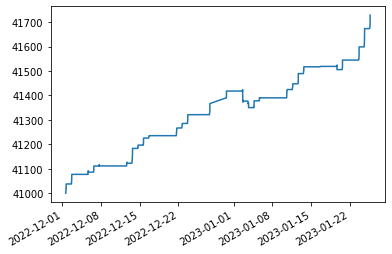

In [18]:
bal_agg_df = pd.concat([*dfs], axis=1).fillna(method='ffill').iloc[1:]
bal_agg_df["TOTAL"] = bal_agg_df.sum(axis = 1)
bal_agg_df["TOTAL"].plot()

In [19]:
days=(bal_agg_df.index[-1]-bal_agg_df.index[0]).days
roi = bal_agg_df.iloc[-1,-1]/bal_agg_df.iloc[0,-1]-1
print(f"Total ROI: {roi:.3%}")
print(f"Over: {days} days")
print(f"Annualized ROI: {(roi+1)**(365/days)-1:.3%}")

Total ROI: 1.776%
Over: 55 days
Annualized ROI: 12.395%


In [53]:
display(bal_agg_df)

,Ryanair@trader_0,Tesla@trader_0,Netflix@trader_0,Google@trader_0,Berkshire Hathaway@trader_0,Amazon@trader_0,Apple@trader_0,Microsoft@trader_0,General Motors@trader_0,Meta@trader_0,...,SAP@trader_0,BP@trader_0,Shell@trader_0,Casio@trader_0,Ferrari@trader_0,Corsair@trader_0,Spotify@trader_0,Doordash@trader_0,Deutsche Bank@trader_0,TOTAL
2022-12-01 14:30:00+00:00,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,41000.000000
2022-12-01 14:35:00+00:00,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,41001.689393
2022-12-01 14:40:00+00:00,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,41001.689393
2022-12-01 14:45:00+00:00,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,41001.689393
2022-12-01 14:50:00+00:00,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.00000,1000.000000,1000.000000,1001.026389,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,41004.414607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-25 16:10:00+00:00,1010.758469,999.746355,1027.108906,1000.80432,1023.373999,1000.66515,1014.045957,1001.902792,1015.378614,1029.306489,...,1010.533415,995.653799,1003.930505,1000.660113,1003.496981,1066.726907,1038.68892,1047.285715,1022.362327,41687.731425
2023-01-25 16:15:00+00:00,1010.758469,999.746355,1027.108906,1000.80432,1023.373999,1000.66515,1014.045957,1001.902792,1015.378614,1029.306489,...,1010.533415,995.653799,1003.930505,1000.660113,1003.496981,1066.726907,1038.68892,1047.285715,1022.362327,41687.731425
2023-01-25 16:20:00+00:00,1010.758469,999.746355,1027.108906,1000.80432,1023.373999,1000.66515,1014.045957,1001.902792,1015.378614,1029.306489,...,1010.533415,995.653799,1003.930505,1000.660113,1003.496981,1066.726907,1038.68892,1047.285715,1022.362327,41687.731425
2023-01-25 16:25:00+00:00,1010.758469,999.746355,1027.108906,1000.80432,1023.373999,1000.66515,1014.045957,1001.902792,1015.378614,1030.408210,...,1010.533415,995.653799,1003.930505,1000.660113,1003.496981,1066.726907,1038.68892,1047.285715,1022.362327,41688.833146


In [59]:
total_prof_trades, total_loosing_trades = 0,0
prof_trd, loos_trd = [], []
for index, values in zip(trades.keys(), trades.values()):
    profitable_trades = list(filter(lambda x: x[1]>0, values))
    loosing_trades = list(filter(lambda x: x[1]<0, values))
    
    total_prof_trades += len(profitable_trades)
    total_loosing_trades += len(loosing_trades)
    
    prof_trd.append(profitable_trades)
    loos_trd.append(loosing_trades)

prof_trd = sum(prof_trd,[])
loos_trd = sum(loos_trd,[])

avg_profit = np.asarray([x[1] for x in prof_trd]).mean()
avg_loss = np.asarray([x[1] for x in loos_trd]).mean()

loosing_trades_mc = [x[1] for x in loos_trd if x[0] == "mc"]
total_loosing_trades_mc = len(loosing_trades_mc)
avg_loss_mc = np.asarray(loosing_trades_mc).mean()

amt_tickers = len(bal_agg_df.columns[:-2])
amt_profitable_tickers = sum(x > 1000 for x in bal_agg_df.iloc[-1].tolist()[:-2])

print(f"Percent of Tickers profitable: {amt_profitable_tickers/amt_tickers:.2%}")
print(f"Percent of winning trades: {total_prof_trades/(total_prof_trades+total_loosing_trades):.2%}")
print(f"Average loss: {avg_loss:.4%}, Average profit: {avg_profit:.4%}")
print(f"Percent of loosing trades due to market close: {total_loosing_trades_mc/total_loosing_trades:.2%}")
    

Percent of Tickers profitable: 92.50%
Percent of winning trades: 72.69%
Average loss: -0.0820%, Average profit: 0.1257%
Percent of loosing trades due to market close: 90.85%
284 258
